In [145]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import readsav
from matplotlib import cm
import cartopy.crs as ccrs
from scipy.ndimage import gaussian_filter
import pickle

homedir = os.path.expanduser("~")
datadir = f"{homedir}/uoedrive/data/gcm_hires/w1049b-sept2025"

In [4]:
# read high-res gcm data
spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time1.txt")
spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time1.txt")
wl = np.loadtxt(f"{datadir}/high-resolution/wavelength_micron.txt")

In [11]:
wl.shape

(460654,)

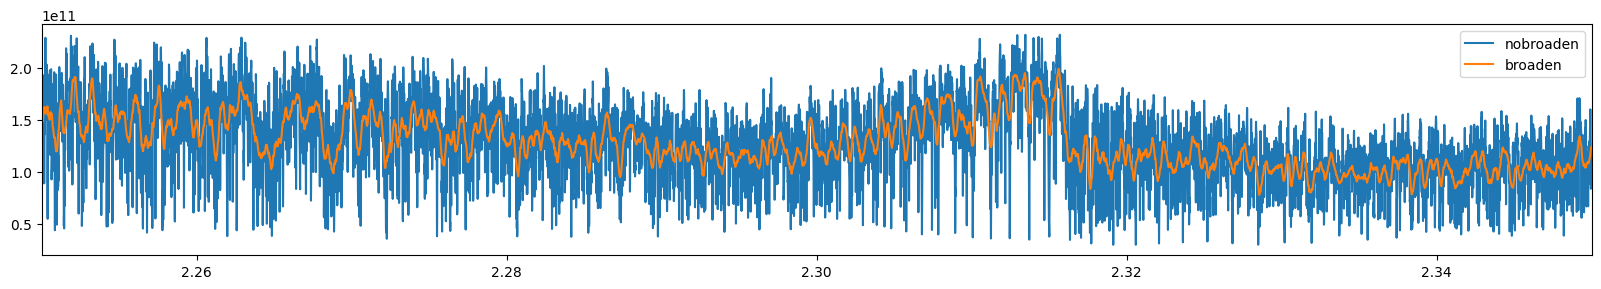

In [5]:
wlind = np.where((wl>2.25) & (wl<2.35))
plt.figure(figsize=(20,3))
plt.plot(wl[wlind], spec_nobroad[wlind], label='nobroaden')
plt.plot(wl[wlind], spectrum[wlind], label='broaden')
plt.xlim(2.25, 2.35)
plt.legend()

In [33]:
np.where((wl>2.3341) & (wl<2.3454))[0].shape

(1207,)

In [138]:
# make data pickles
# wav is [nchip, npix]
# obs is [nt, nchip, npix]
chipswl = [(2.225,2.241),(2.242,2.256),(2.300,2.317),(2.318,2.334)] # K2148
chipswl = [(2.2876, 2.3003),(2.3038, 2.3160),(2.3193, 2.3310),(2.3341, 2.3454)] # oiginal CRIRES
npix = 1206
wav = np.empty((len(chipswl), npix))
observed = np.empty((20, len(chipswl), npix))
error = np.empty((20, len(chipswl), npix))
template = np.empty((20, len(chipswl), npix))

for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time{t+1}.txt")
    for chip in range(len(chipswl)):
        wlmin, wlmax = chipswl[chip]
        wlind = np.where((wl>wlmin) & (wl<wlmax))
        wav[chip] = wl[wlind][:npix]
        data = spectrum[wlind][:npix]
        model = spec_nobroad[wlind][:npix]
        observed[t,chip] = data/np.nanmedian(data)
        template[t, chip] = model/np.nanmedian(model)
        size = 5
        sigma = np.array([np.std(observed[t,chip][max(0,i-size):min(len(data),i+size+1)]) for i in range(len(data))]) # local running std as error
        error[t,chip] = sigma

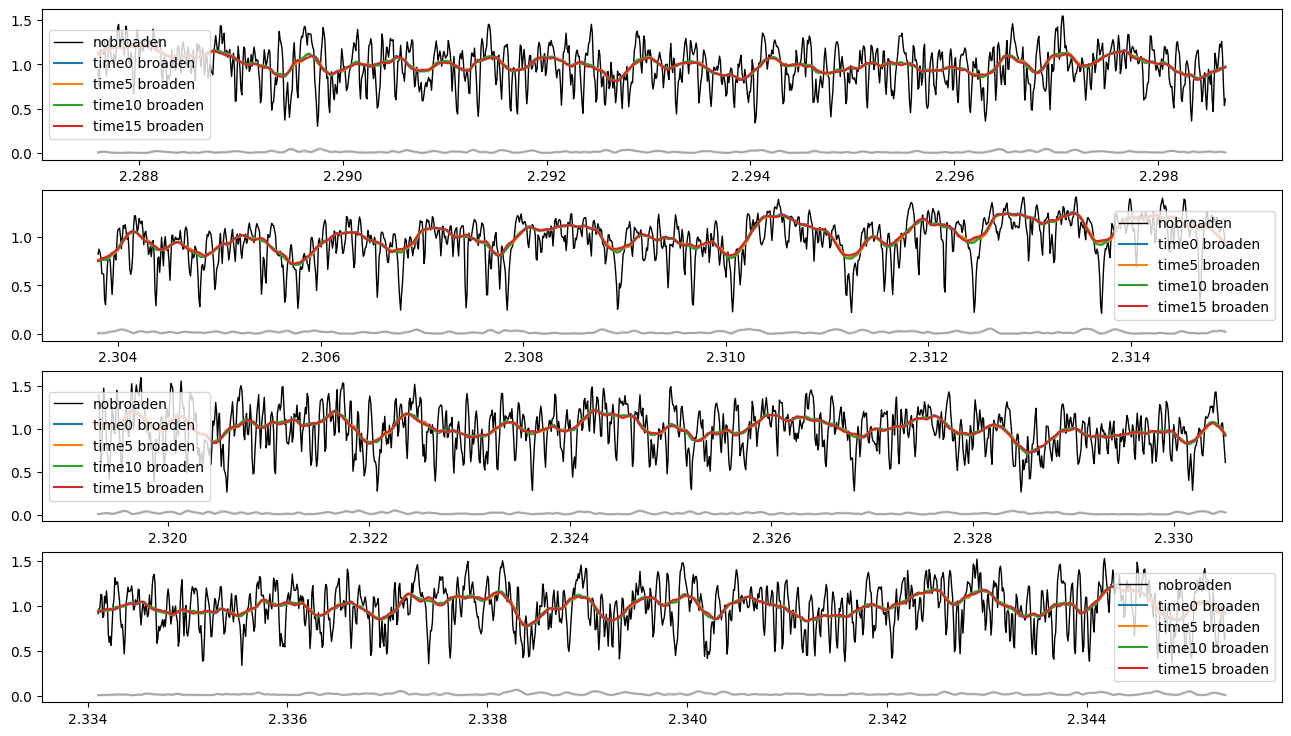

In [139]:
plt.figure(figsize=(16,9))
for chip in range(len(chipswl)):
    wlmin, wlmax = chipswl[chip]
    plt.subplot(len(chipswl),1,chip+1)
    plt.plot(wav[chip], np.nanmedian(template[:,chip,:],axis=0), color='k', linewidth=1, label=f'nobroaden')
    for t in [0,5,10,15]:
        plt.plot(wav[chip], observed[t,chip], label=f'time{t} broaden')
        plt.plot(wav[chip], error[t,chip], color='k', alpha=0.1)
    plt.legend()

In [36]:
# read t1500g1000f8 model
with open(f'../data/fitted/CRIRES_W1049B_K_t1500g1000f8.pickle', 'rb') as f:
    pickl = pickle.load(f)

In [90]:
def make_deltaspec(loc, ew, win, **kw):
    """
    Create a delta-function line spectrum based on a wavelength grid
    and a list of line locations and equivalent widths.

    :INPUTS:
       loc -- location of lines in the emission frame of reference

       ew  -- equivalent widths of lines, in units of wavelength grid.
               Positive values are emission lines.

       win -- wavelength grid in the emission frame, with values
              monotonically increasing (best if it is linearly spaced)

       All inputs should be lists or one-dimensional arrays of scalars

    :OPTIONAL_INPUTS:
       cont=None -- set continuum values in the emission frame;

       nearest=False  -- if True, use full pixels instead of partial

       verbose=False  -- if True, print out various messages

    :OUTPUTS:
      s  -- delta-function line spectrum, with a continuum level of zero
    
    :EXAMPLE: (NEEDS TO BE UPDATED!):
       ::

          w   = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]
          loc = [2.1, 2.35, 2.62]
          ew  = [0.1, .02, .01]
          s = linespec(loc, ew, w)
          print s  #  --->  [0, 1, 0, 0.1, 0.1, 0, 0.08, 0.02]

    :NOTE:  This may give incorrect results for saturated lines.
    """
    # 2008-12-05 13:31 IJC: Created
    # 2008-12-10 13:30 IJC: Added continuum option, reworked code some.
    # 2008-12-12 12:33 IJC: Removed RV option

    # Check inputs
    loc = np.array(loc).copy().ravel()
    ew  = np.array(ew ).copy().ravel()
    win = np.array(win).copy().ravel()

    defaults = dict(cont=None, nearest=False, verbose=False)
    for key in defaults:
        if (not key in kw):
            kw[key] = defaults[key]
    verbose = bool(kw['verbose'])
    nearest = bool(kw['nearest'])
    contset = kw['cont']!=None

    if contset:
        cont = np.array(kw['cont']).copy()
        if len(cont)!=len(win):
            print( "Wavelength grid and continuum must have the same length!")
            return -1
    else:
        cont = np.ones(win.shape)

    nlines = len(loc)
    if nlines != len(ew):
        if verbose:  print( "len(loc)>>" + str(len(loc)))
        if verbose:  print( "len(ew)>>" + str(len(ew)))
        print( "Line locations and equivalent widths must have same length!")
        return -1

    # Only use lines in the proper wavelength range
    nlineinit = len(loc)
    lind = (loc>=win.min()) * (loc<=win.max())
    loc = loc[lind]
    ew  =  ew[lind]
    nlines = len(loc)

    s = cont.copy()
    d = np.diff(win).mean()

    if verbose:  print( "s>>" + str(s))

    for ii in range(nlines):
        lineloc = loc[ii]
        lineew  = ew[ii]
        index = (win<lineloc).sum() - 1
        if nearest:
            s[index+1] = s[index]-cont[index]*lineew/d
        elif index==len(win):
            s[index] = s[index] - cont[index]*lineew/d
        else:
            s[index] = s[index] - lineew*cont[index]* \
                (win[index+1] - lineloc)/d/d
            s[index+1] = s[index+1] - lineew*cont[index+1] * \
                (lineloc - win[index])/d/d
        
        if verbose:  
            print( "(lineloc, lineew)>>" + str((lineloc, lineew)))
            print( "(index, d)>>" + str((index,d)))

    if verbose:
        print( "(nlineinit, nline)>>" + str((nlineinit, nlines)))
    return s

In [141]:
line_file = f'../data/linelists/linbroad_t1500g1000f8_edited.clineslsd'
with open(line_file, 'r') as f:
    raw = f.readlines()
dat = np.zeros([len(raw), 2], dtype=float)                                                 
for i, line in enumerate(raw):                                         
    dat[i,:]= list(map(float, line.split()[0:2]))
lineloc = dat[:,0]/1e4
lineew = dat[:,1]/1e3

rv=9e-5
shift = 1. + rv
wlind = np.where((wl>2.25) & (wl<2.35))
dwl = wl[wlind]
deltaspec = make_deltaspec(lineloc*shift, lineew, dwl, verbose=False)

chip=0, wl=(2.2876, 2.3003)
chip=1, wl=(2.3038, 2.3160)
chip=2, wl=(2.3193, 2.3310)
chip=3, wl=(2.3341, 2.3454)


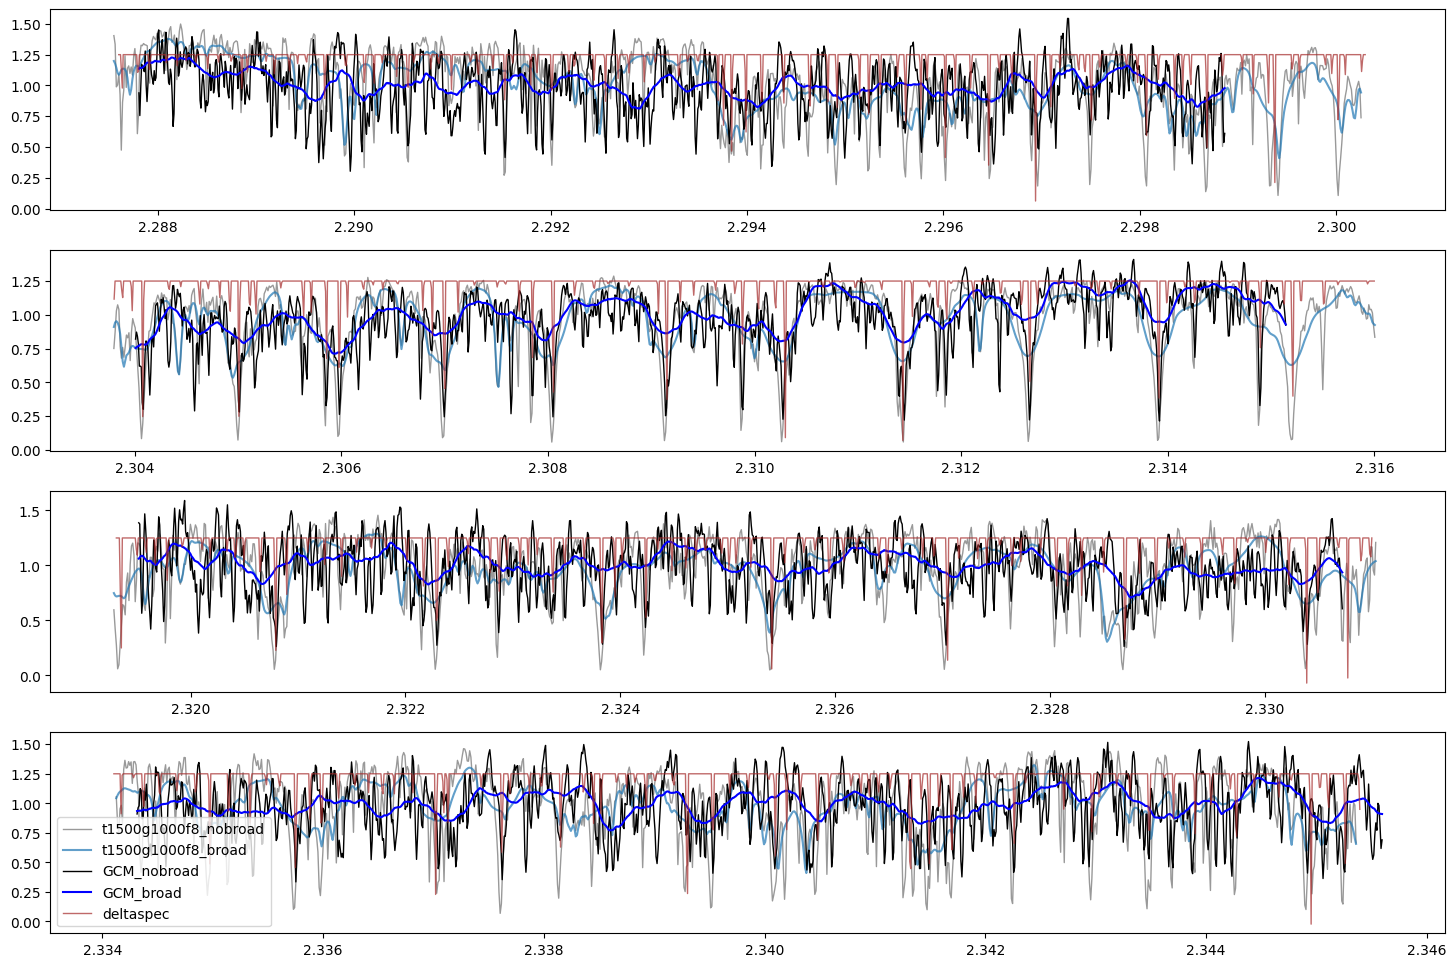

In [142]:
plt.figure(figsize=(18,12))
t=0
rvgcm = 9.e-5 #um
for chip in range(4):
    wlmin, wlmax = chipswl[chip]
    print(f"chip={chip}, wl=({pickl['chiplams'][t,chip].min():.4f}, {pickl['chiplams'][t,chip].max():.4f})")
    plt.subplot(len(chipswl),1,chip+1)
    plt.plot(pickl['chiplams'][t,chip], pickl['chipmodnobroad'][t,chip], color='k', linewidth=1, alpha=0.4, label='t1500g1000f8_nobroad')
    plt.plot(pickl['chiplams'][t,chip], pickl['chipmods'][t,chip], alpha=0.7, label='t1500g1000f8_broad')
    plt.plot(wav[chip]*(1+rvgcm), np.nanmedian(template[:,chip,:],axis=0), color='k', linewidth=1, label=f'GCM_nobroad')
    plt.plot(wav[chip]*(1+rvgcm), observed[t,chip], color='blue',label=f'GCM_broad')
    for line in lineloc:
        if line > wlmin and line < wlmax:
            plt.axvline(line*shift, ymax=0.8, ymin=0.2, color='r', alpha=0.0)
    dwlind = np.where((dwl>wlmin) & (dwl<wlmax))
    plt.plot(dwl[dwlind], 1.25+deltaspec[dwlind]/0.7e5, linewidth=1, color="brown", alpha=0.7, label='deltaspec')
plt.legend() 

In [143]:
spec_nobroad_all = []
for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spec_nobroad_all.append(spec_nobroad)
spec_nobroad_all = np.array(spec_nobroad_all)
spec_nobroad_all.shape

(20, 460654)

In [10]:
wav.shape

(4, 1550)

In [15]:
np.diff(wl).mean()

9.1468790608115e-06

In [24]:
from scipy.interpolate import interp1d
spec_nobroad_mean = np.nanmedian(spec_nobroad_all,axis=0)
wl_lin = np.arange(1.51, 2.50+0.05*1e-4, 0.05*1e-4, dtype=np.float32)  # Include endpoint
interp_func = interp1d(wl, spec_nobroad_mean, kind='linear', bounds_error=False, fill_value=0.0)
spec_nobroad_lin = interp_func(wl_lin)
spec_nobroad_lin.shape

(198001,)

In [25]:
# save 'model' to fits

hdu = fits.PrimaryHDU(spec_nobroad_lin.astype(np.float32))

# WCS header keywords
hdu.header['CRPIX1'] = 1                     # Reference pixel
hdu.header['CRVAL1'] = 15100          # Wavelength at reference pixel
hdu.header['CDELT1'] = 0.05           # Step size
hdu.header['CTYPE1'] = 'LINEAR'

# Write to FITS
hdu.writeto(f'{datadir}/w1049b_gcmhires_nobroad_lin.fits', overwrite=True)

In [144]:
# prepare pickle file
saveout = dict(
    chiplams=np.tile(wav, (20, 1, 1)), 
    chipmodnobroad=template, 
    observed=observed, 
    error=error)
with open(f'../data/fitted/ELT_W1049B_K_gcm.pickle', 'wb') as f:
    pickle.dump(saveout, f)

### Plot flux maps

In [ ]:
fluxmap = np.loadtxt(f"{datadir}/bolometric_flux_map_data/spectrum_erg.s.cm3_broaden_time1.txt")

In [166]:
# Initialize parameters
ntracer = 7  # number of tracers of the GCM.  
							#tracer 1 is silicate vapor, tracer 2 and 3 are silicate
              # cloud mode 1 and 2; tracer 4 is Fe vapor and tracer 5 is
            	# Fe cloud; tracer 6 is Na2S vapor and tracer 7 is Na2S cloud

# Read information of the GCM
with open(f'{datadir}/bolometric_flux_map_data/infmitgcm.txt', 'r') as f:
    lines = f.readlines()
    # Find maximum number of columns
    max_cols = max(len(line.split()) for line in lines)
    # Pad shorter rows with NaN
    data = []
    for line in lines:
        parts = line.split()
        if len(parts) < max_cols:
            parts += ['NaN'] * (max_cols - len(parts))
        data.append(parts)
    inf = np.array(data, dtype=float)

# Extract parameters 
nlx = int(inf[0, 0])     # number of longitude points
nly = int(inf[0, 1])     # number of latitude points
Nr = int(inf[0, 2])      # number of vertical layers
ntime = 20 #int(inf[0, 3])   # number of time outputs
pc = inf[2, :Nr]         # pressure grid, unit [Pa]
xi = inf[6, :nlx]        # longitude grid, unit [degree]
yi = inf[7, :nly]        # latitude grid, unit [degree]
deltaT = 940.5 #inf[5, 0]       # time step of the GCM, second
gravity = inf[1, 0]      # surface gravity, unit [m/s2]
rSphere = inf[1, 1]      # radius, unit [m]
rotationperiod = inf[1, 2]  # rotation period, unit [second]
timeout = 1200004. + np.arange(ntime) * deltaT #inf[4, :ntime]    # time steps of outputs
print(f"ntime={ntime}, deltaT={deltaT}, period={rotationperiod}, timeout={timeout}")

# Read tracer array
with open(f'{datadir}/bolometric_flux_map_data/fluxtopmitgcm.dat', 'rb') as f:
    tempe = np.fromfile(f, dtype=np.float32, count=nlx*nly*ntime)
flux = tempe.reshape((nlx, nly, ntime), order='F')
flux[:, 0, :] = flux[:, 1, :]
flux[:, -1, :] = flux[:, -2, :]

ntime=20, deltaT=940.5, period=19008.0, timeout=[1200004.  1200944.5 1201885.  1202825.5 1203766.  1204706.5 1205647.
 1206587.5 1207528.  1208468.5 1209409.  1210349.5 1211290.  1212230.5
 1213171.  1214111.5 1215052.  1215992.5 1216933.  1217873.5]


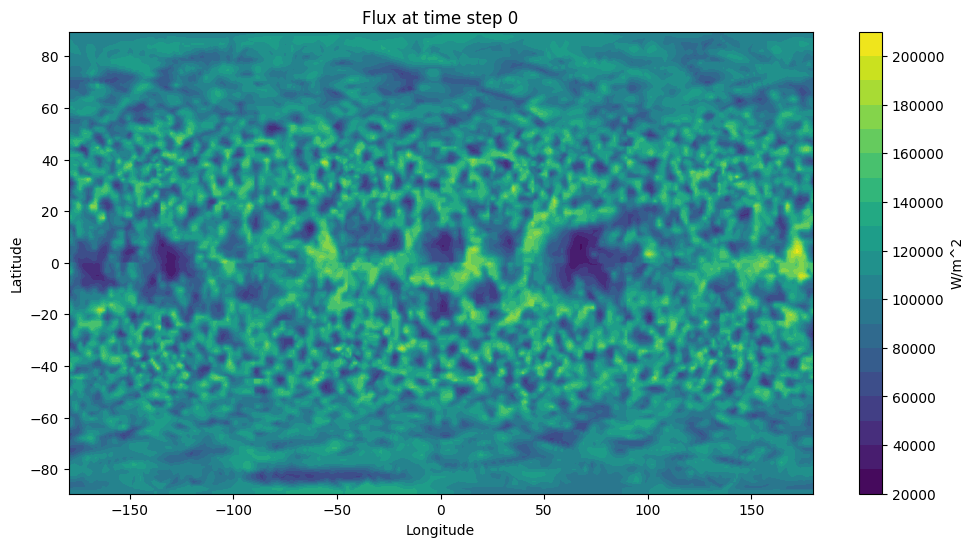

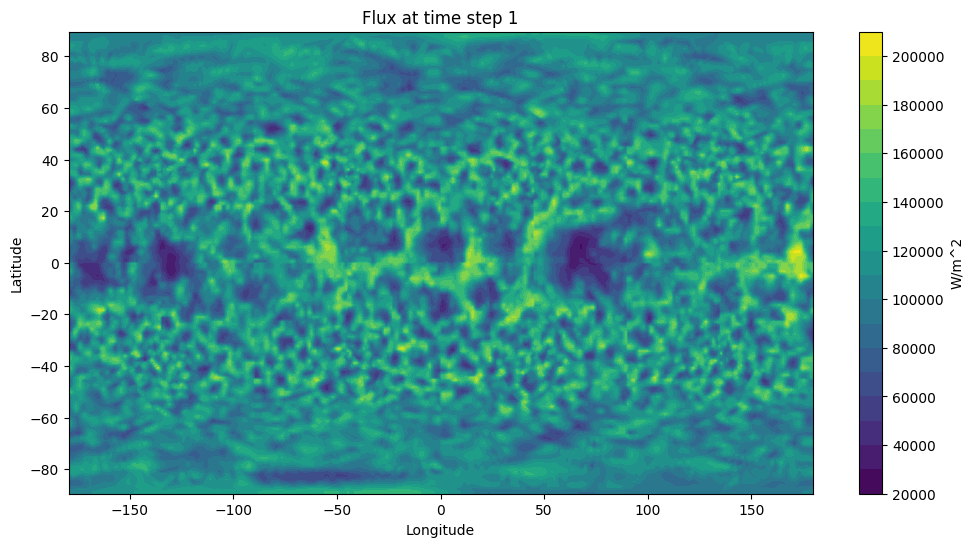

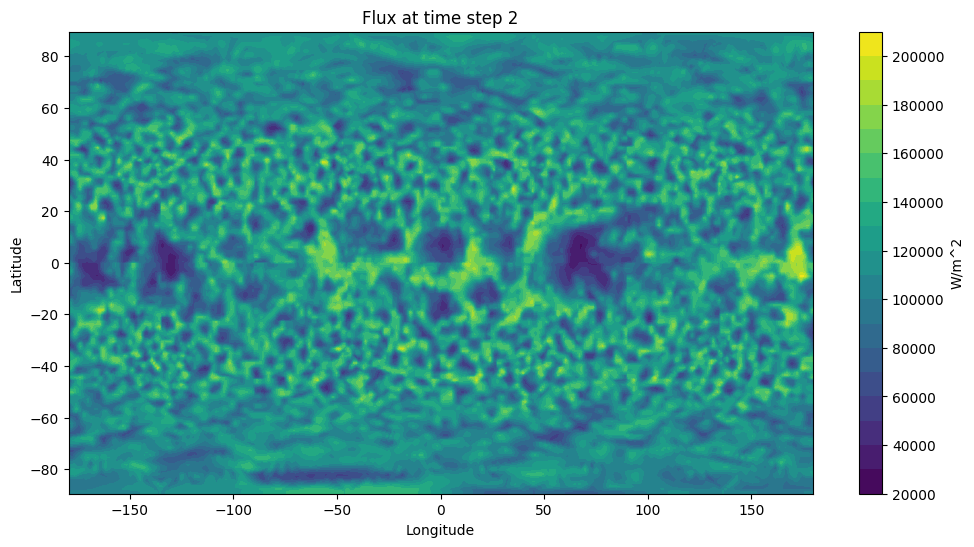

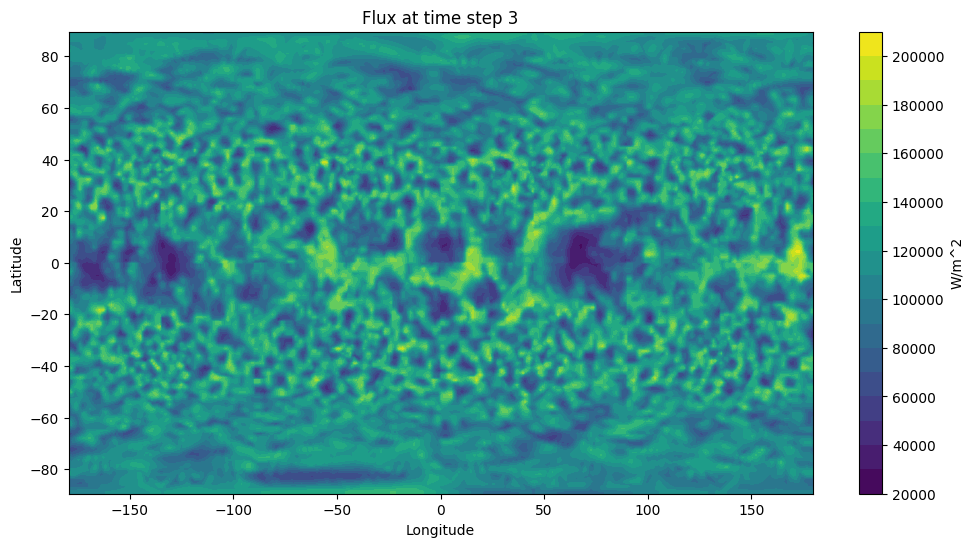

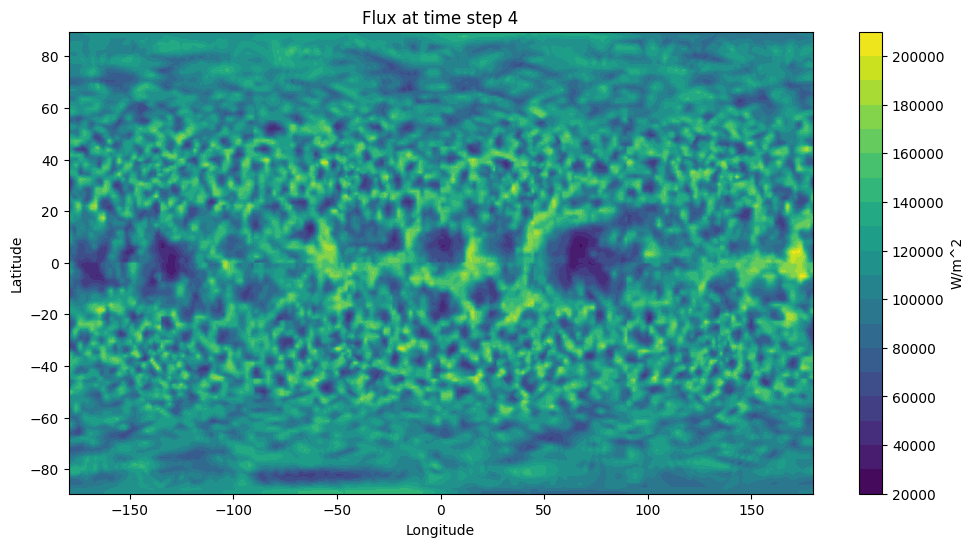

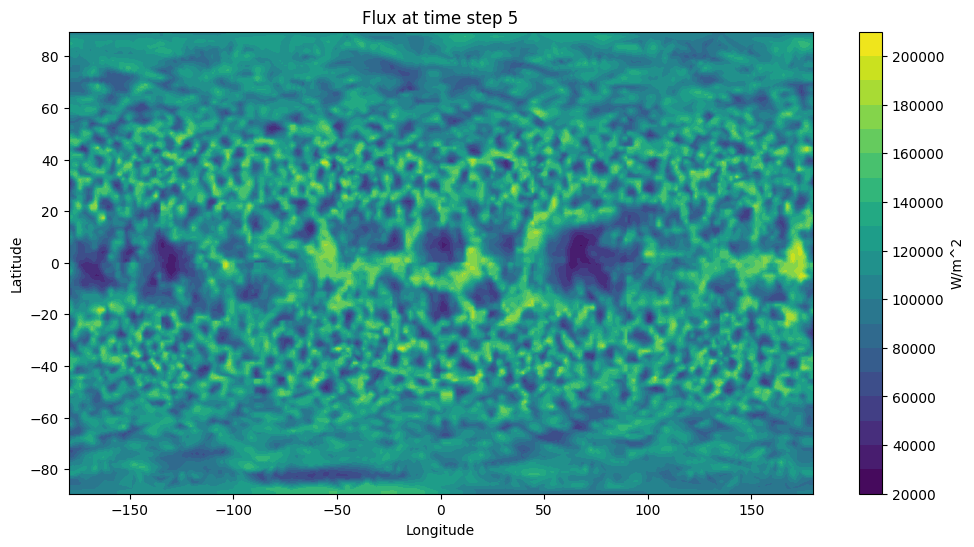

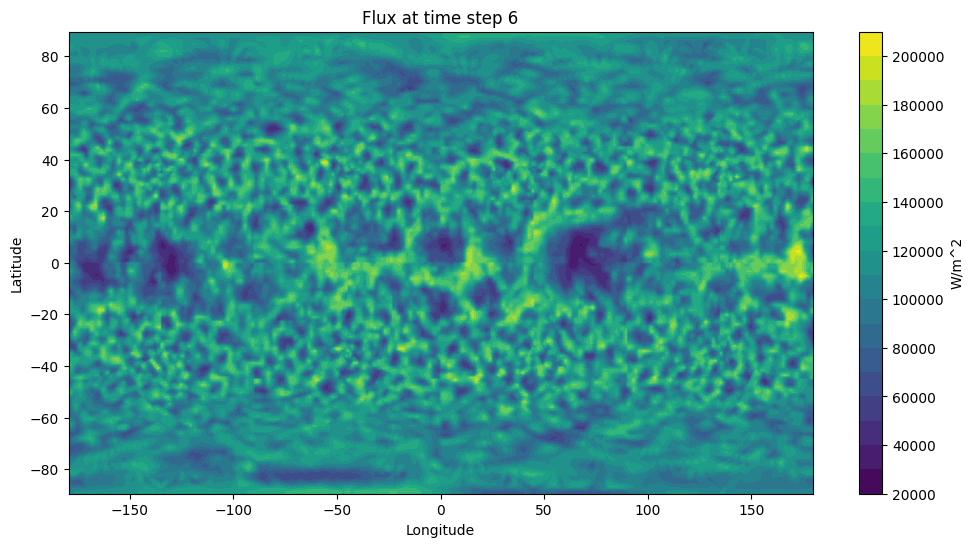

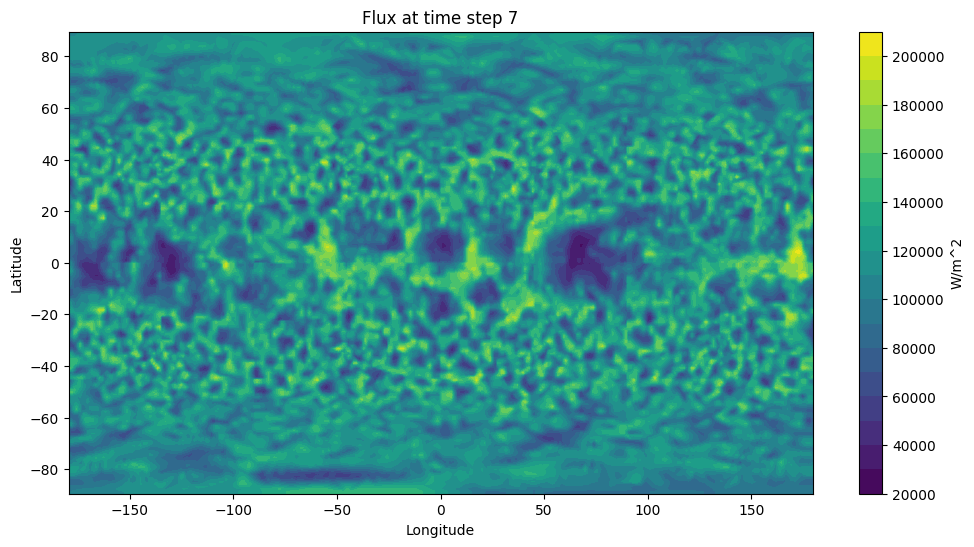

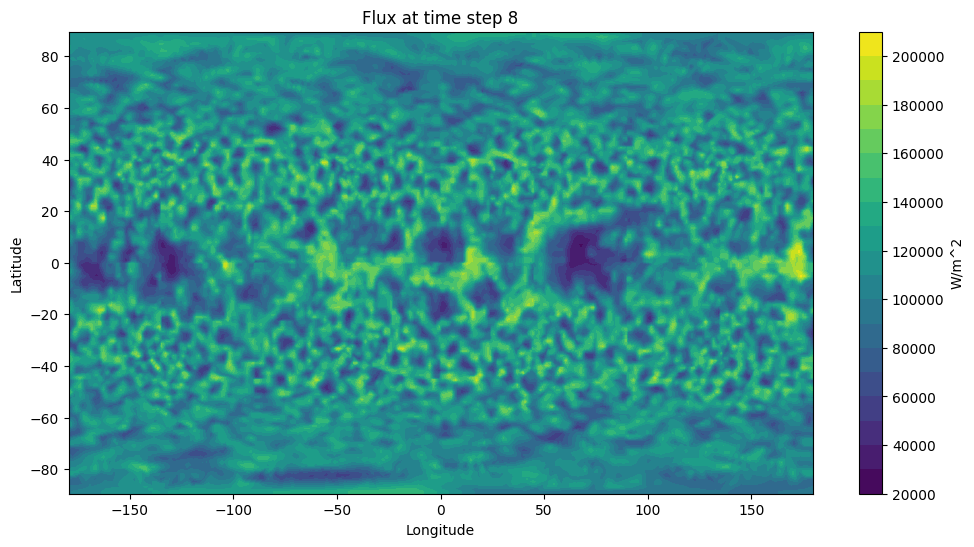

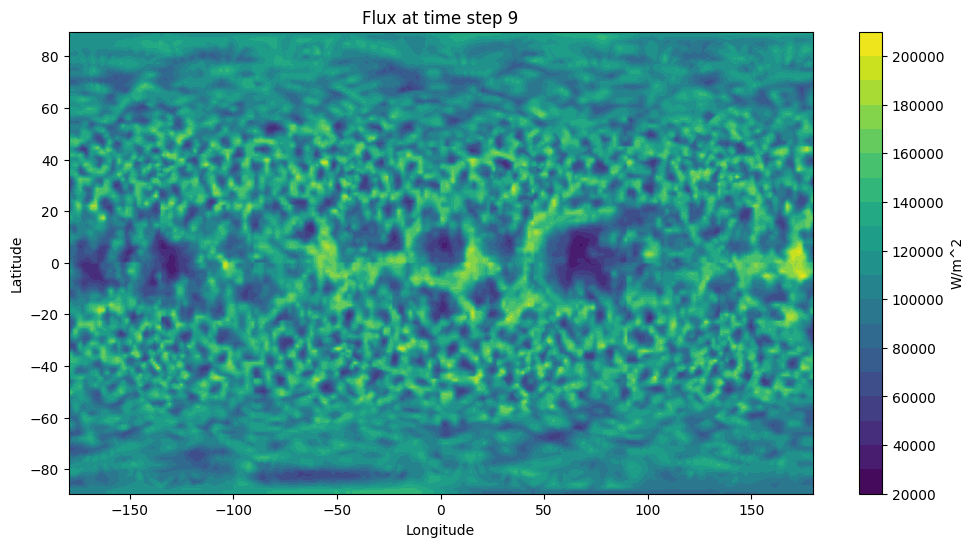

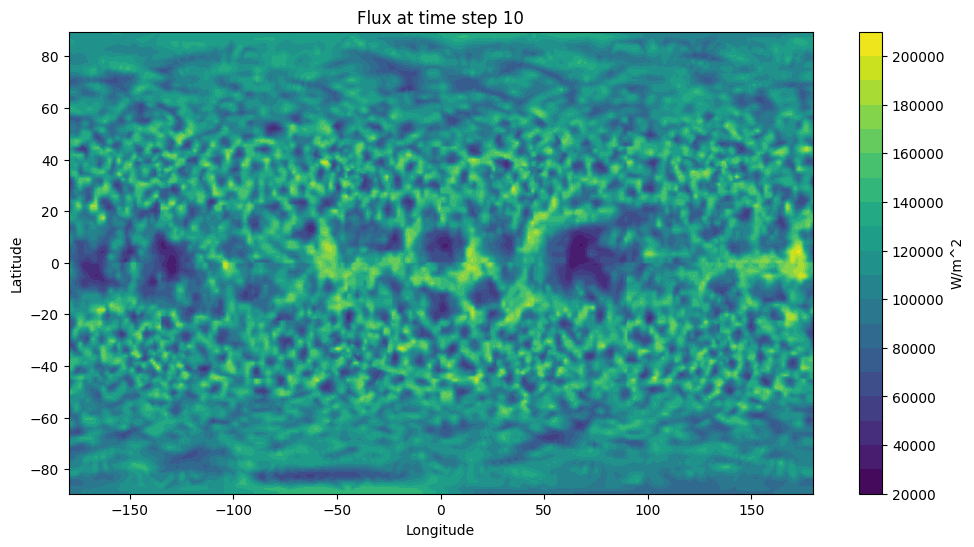

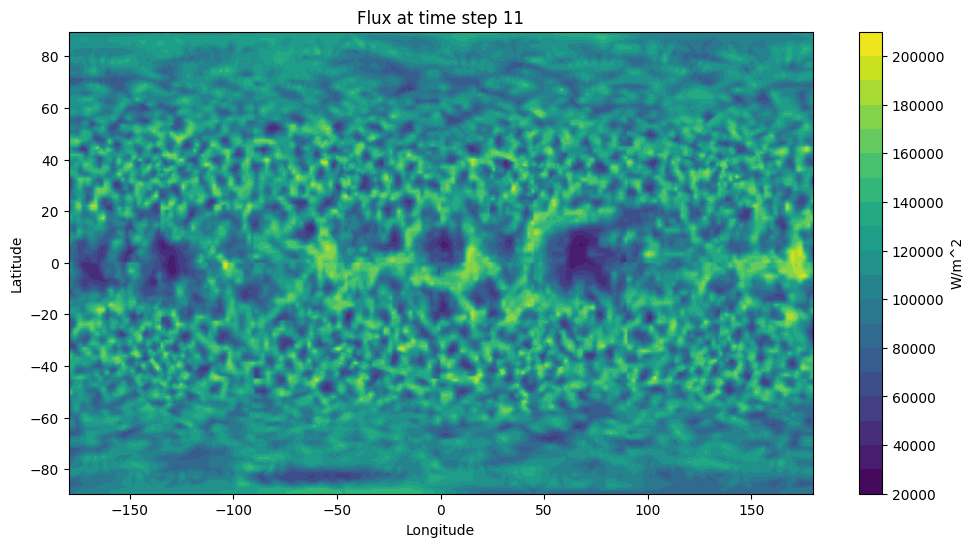

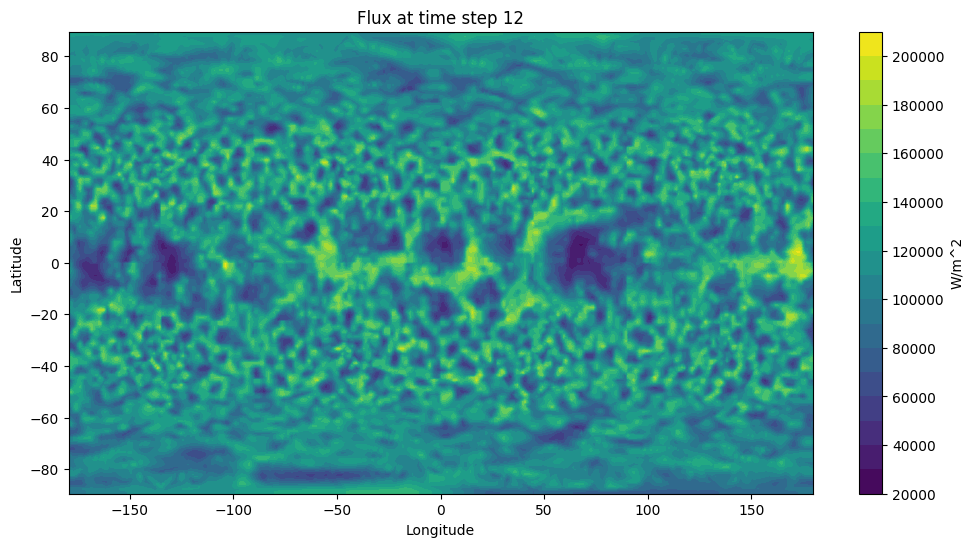

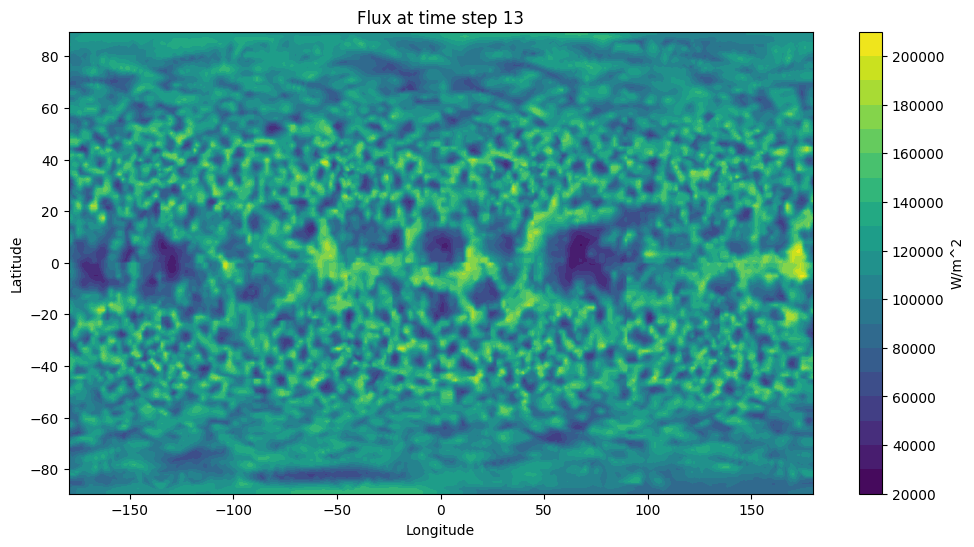

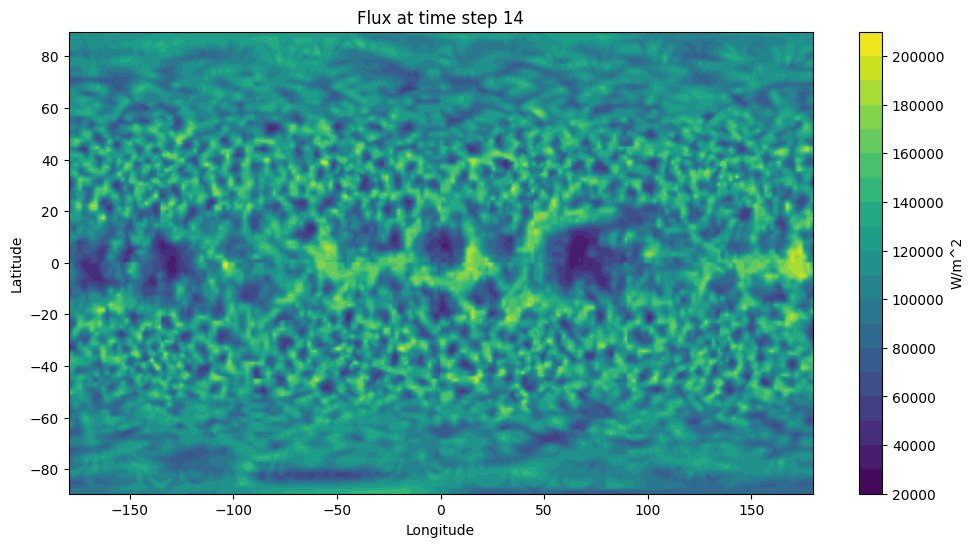

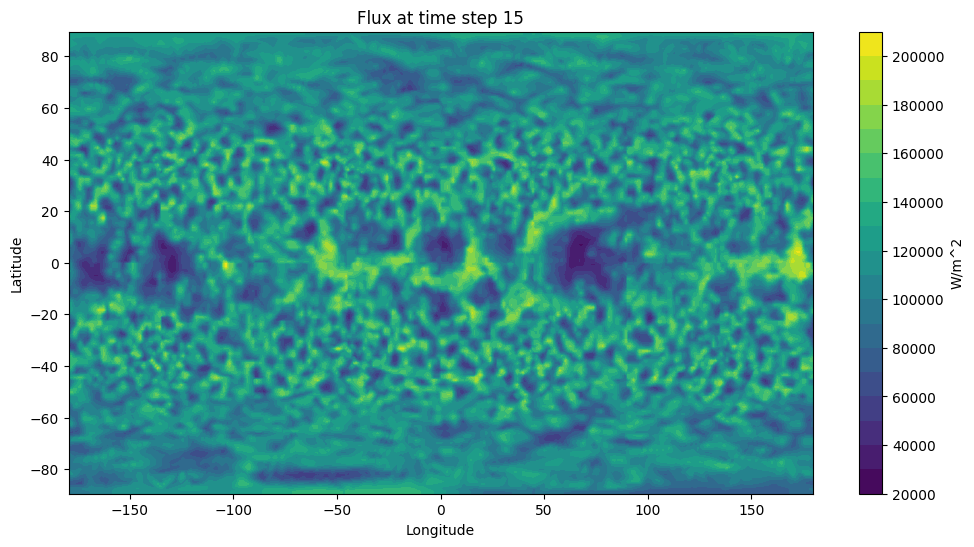

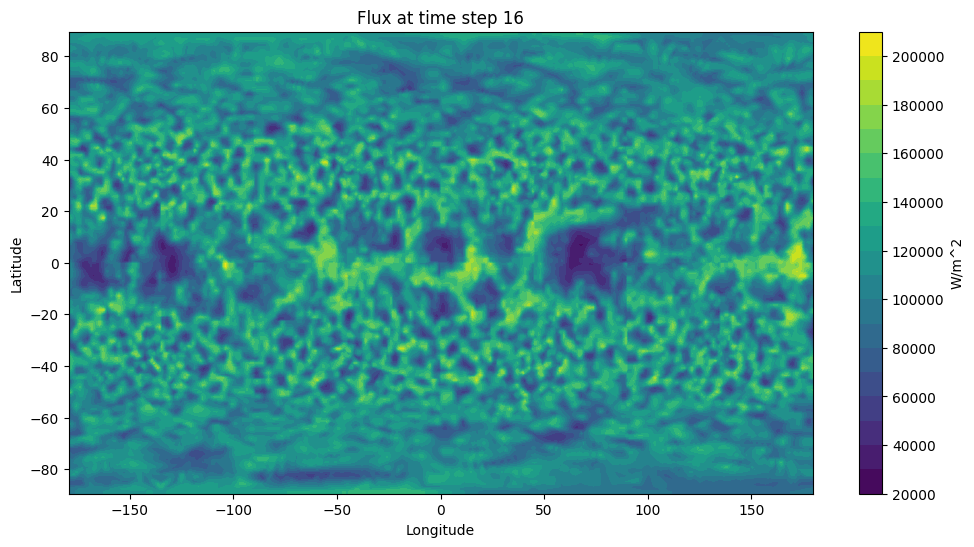

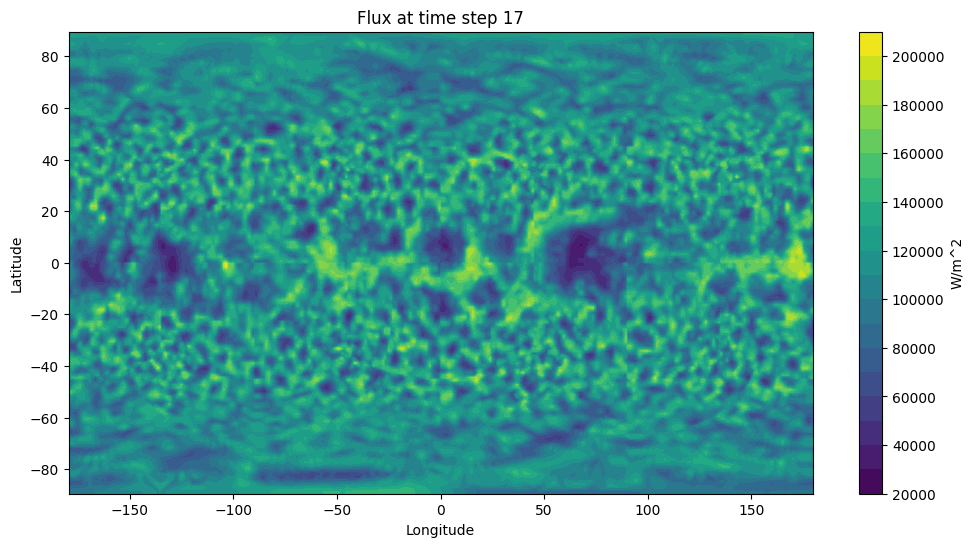

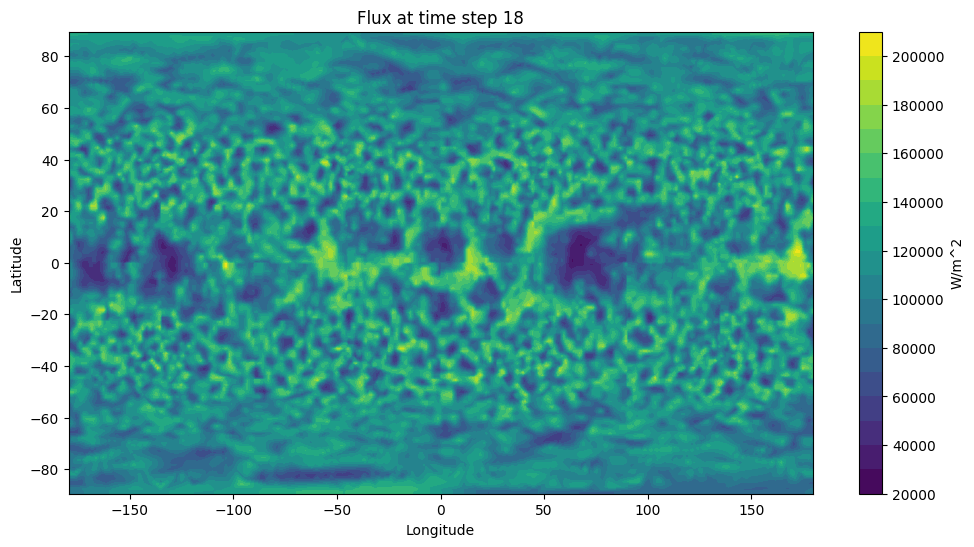

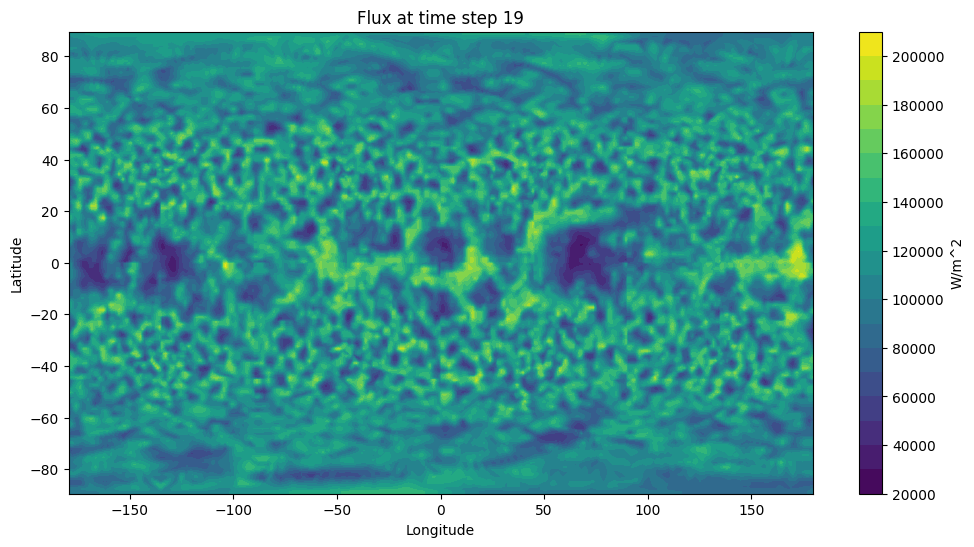

In [167]:
# Plotting
nlayer = 19  # 0-based indexing for 20th layer
timeuse = 20

for timeuse in range(20):
    plt.figure(figsize=(12, 6))

    plt.contourf(xi, yi, flux[:, :, timeuse].T, levels=20, cmap='viridis')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    cbar = plt.colorbar()
    cbar.set_label('W/m^2')
    plt.title(f'Flux at time step {timeuse:.0f}')
    plt.savefig(f'{datadir}/bolometric_flux_map_data/flux_map_time{timeuse}.png', dpi=100)

plt.show()